# 8.2 Bagging, Random Froest, Boosting

常见的集成学习框架有三种：Bagging，Boosting 和 Stacking。三种集成学习框架在基学习器的产生和综合结果的方式上会有些区别。首先，从概念上理解一下。

Bagging 全称叫 Bootstrap aggregating。每个基学习器都会对训练集进行有放回抽样得到子训练集，比较著名的采样法为0.632自助法。每个基学习器基于不同子训练集进行训练，并综合所有基学习器的预测值得到最终的预测结果。Bagging 常用的综合方法是投票法，票数最多的类别为预测类别。
<img src="img/bagging.jpg" style="zoom:50%" />

Boosting 训练过程为阶梯状，基模型的训练是有顺序的，每个基模型都会在前一个基模型学习的基础上进行学习，最终综合所有基模型的预测值产生最终的预测结果，用的比较多的综合方式为加权法。
<img src="img/boosting.jpg" style="zoom:50%" />

Stacking 是先用全部数据训练好基模型，然后每个基模型都对每个训练样本进行的预测，其预测值将作为训练样本的特征值，最终会得到新的训练样本，然后基于新的训练样本进行训练得到模型，然后得到最终预测结果。
<img src="img/stacking.jpg" style="zoom:50%" />

## 8.2.1 偏差与方差

在介绍了集成学习的基本概念之后，我们先介绍下如何从偏差和方差的角度来理解集成学习。

偏差（Bias）描述的是预测值和真实值之差；
方差（Variance）描述的是预测值作为随机变量的离散程度。

<img src="img/var.jpg" style="zoom:50%" />

我们常说集成学习中的基模型是弱模型，通常来说弱模型是偏差高（在训练集上准确度低）方差小（防止过拟合能力强）的模型，**但并不是所有集成学习框架中的基模型都是弱模型。Bagging 和 Stacking 中的基模型为强模型（偏差低，方差高），而Boosting 中的基模型为弱模型（偏差高，方差低）。**

## 8.2.2 选择合适的集成方式

在 Bagging 和 Boosting 框架中，通过计算基模型的期望和方差我们可以得到模型整体的期望和方差。为了简化模型，我们假设基模型的期望为$\mu$，方差$\sigma^2$ ，基模型$i$的权重为$r_i$，两两模型间的相关系数$\rho$相等。由于 Bagging 和 Boosting 的基模型都是线性组成的，那么有：

模型总体期望：
$$
\begin{aligned}
E(F) &=E\left(\sum_{i}^{m} r_{i} f_{i}\right) \\
&=\sum_{i}^{m} r_{i} E\left(f_{i}\right)
\end{aligned}
$$
模型总体方差（公式推导参考协方差的性质，协方差与方差的关系）：
$$
\begin{aligned}
\operatorname{Var}(F) &=\operatorname{Var}\left(\sum_{i}^{m} r_{i} f_{i}\right) \\
&=\sum_{i}^{m} \operatorname{Var}\left(r_{i} f_{i}\right)+\sum_{i \neq j}^{m} \operatorname{Cov}\left(r_{i} f_{i}, r_{j} f_{j}\right) \\
&=\sum_{i}^{m} r_{i}^{2} \operatorname{Var}\left(f_{i}\right)+\sum_{i \neq j}^{m} \rho r_{i} r_{j} \sqrt{\operatorname{Var}\left(f_{i}\right)} \sqrt{\operatorname{Var}\left(f_{j}\right)} \\
&=m r^{2} \sigma^{2}+m(m-1) \rho r^{2} \sigma^{2}
\end{aligned}
$$

模型的准确度可由偏差和方差共同决定：
$$
\text { Error }=\text { bias }^{2}+\text { var }+\xi
$$

对于bagging而言，$r = \frac{1}{m}$:
$$
\begin{aligned}
E(F) &=\sum_{i}^{m} r_{i} E\left(f_{i}\right) \\
&=m \frac{1}{m} \mu \\
&=\mu
\end{aligned}
$$

$$
\begin{aligned}
\operatorname{Var}(F) &=m r^{2} \sigma^{2}+m(m-1) \rho r^{2} \sigma^{2}\\
&=\frac{\sigma^{2}}{m}+\frac{(m-1)}{m} \rho \sigma^{2}
\end{aligned}
$$

由于采用随机抽样的方式，$\rho$近似认为等于0。随着$m$增大，整体模型的方差在减小。**由此可见，bagging适用于强模型（偏差低，方差高），能通过随机抽样取平均的方式，降低其方差。**

对于 Boosting 来说，由于基模型共用同一套训练集，所以基模型间具有强相关性，故模型间的相关系数近似等于 1，针对 Boosting 化简公式为：
$$
E(F)=\sum_{i}^{m} r_{i} E\left(f_{i}\right)
$$
$$
\begin{aligned}
\operatorname{Var}(F) &=m r^{2} \sigma^{2}(1-\rho)+m^{2} r^{2} \sigma^{2} \rho \\
&=m \frac{1}{m^{2}} \sigma^{2}(1-1)+m^{2} \frac{1}{m^{2}} \sigma^{2} 1 \\
&=\sigma^{2}
\end{aligned}
$$

至于boosting减小偏差的原理，在之后会详细介绍。

## 8.2.3 如何衡量模型的独立性？

抽样的随机性决定了模型的随机性，如果两个模型的训练集抽样过程不独立，则两个模型则不独立。这时便有一个天大的陷阱在等着我们：bagging中基模型的训练样本都是独立的随机抽样，但是基模型却不独立呢？

我们讨论模型的随机性时，抽样是针对于样本的整体。而bagging中的抽样是针对于训练集（整体的子集），所以并不能称其为对整体的独立随机抽样。那么到底bagging中基模型的相关性体现在哪呢？

样本抽样：整体模型F(X1, X2, ..., Xn)中各输入随机变量（X1, X2, ..., Xn）对样本的抽样

子抽样：从整体模型F(X1, X2, ..., Xn)中随机抽取若干输入随机变量成为基模型的输入随机变量

假若在子抽样的过程中，两个基模型抽取的输入随机变量有一定的重合，那么这两个基模型对整体样本的抽样将不再独立，这时基模型之间便具有了相关性。

In [1]:
# Usual Packages
import pandas as pd
import numpy as np
import random
import os
import math

In [2]:
# Machine Learning Packages

# Train & Test Split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Single Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
# Bagging 
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
# Random Forest
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
# Boosting
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
# Evaluation Metrics
from sklearn import metrics
# draw figures
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# 预处理
Heart = pd.read_csv(r'数据\Heart.csv',index_col=0).dropna()

from sklearn import preprocessing
le = preprocessing.LabelEncoder()  
# preprocessing.LabelEncoder() 将类别使用0-n_classes-1来编码标签

qualitative_columns = ['ChestPain','Thal','AHD']
for column in qualitative_columns:
    Heart[column] = le.fit_transform(Heart[column])
  
X = Heart.drop('AHD',axis=1)
y = Heart['AHD']

Heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0,0
2,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1,1
3,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1
4,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1,0


In [4]:
# 简单决策树
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

single_tree_clf = DecisionTreeClassifier(random_state=0)
single_tree_clf.fit(X_train,y_train)
print('single_tree train_accuracy: %s'%(single_tree_clf.score(X_train,y_train)))

y_test_pred = single_tree_clf.predict(X_test)
print('single_tree test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

single_tree train_accuracy: 1.0
single_tree test_accuracy: 0.697986577181208


test_size：训练集数据大小，是样本数据的一个比例值。上式是样本数据的50%。

random_state：划分数据时需要产生随机种子，设置为None则每次调用numpy.random，这样的话每次运行会得到不一样的结果，由于随机性发生改变。当然你可以输入一个int值作为随机种子，最好在0-42之间。

sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

## 8.2.4 Bagging

8.1 节中讨论的决策树存在高方差。这意味着如果我们将训练数据随机分成两部分，并分别拟合决策树，我们得到的结果可能会大不相同。

因此，减少方差并因此提高统计学习方法的预测准确性的一种自然方法是从总体中获取许多训练集，使用每个训练集构建单独的预测模型，并对结果预测进行平均。

$$
\hat{f}_{\text {bag }}(x)=\frac{1}{B} \sum_{b=1}^{B} \hat{f}^{*b}(x)
$$

![title](img/bootstrap.PNG)

相同评价指标，不同样本

一、oob（Out - of - Bag）

定义：放回取样导致一部分样本很有可能没有取到，这部分样本平均大约有 37% ，把这部分没有取到的样本称为 oob 数据集；

使用OOB-袋外错误率时，可以不对数据集进行 train_test_split。也就是在全集随机有放回取样得到训练集（假设取样大小等于全集），使用没有取到的样本做测试集。

![title](img/oob.PNG)

 参数：OOB-袋外错误率

1）对每个样本，计算它作为oob样本的树和它的分类情况（约1/3的树）；

2）然后以简单多数投票作为该样本的分类结果；

3）最后用误分个数占样本总数的比率作为随机森林的oob误分率。
<img src="img/oob示意.jpg" style="zoom:50%" />

oob误分率是随机森林泛化误差的一个无偏估计，它的结果近似于需要大量计算的k折交叉验证。

In [5]:
# Bagging
# OOB_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

bagging_clf_OOB = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=True,n_jobs=-1)
bagging_clf_OOB.fit(X,y)
print('Bagging oob_score: %s'%(bagging_clf_OOB.oob_score_))

# test_score
bagging_clf_test = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=False,n_jobs=-1)
bagging_clf_test.fit(X_train,y_train)
y_test_pred = bagging_clf_test.predict(X_test)
print('Bagging test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

Bagging oob_score: 0.7777777777777778
Bagging test_accuracy: 0.785234899328859


BaggingClassifier(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
* base_estimator：object, default=None
				适合于数据集的随机子集的基估计量。
				如果 None，则基估计量是决策树。
* n_estimators：int, default=10
			  训练基学习器（基本估计器）的个数。
* max_samples：int or float, default=1.0
			 从X抽取的样本数，用于训练每个基本估计器
			 如果为int，则抽取 max_samples 个样本。
			 如果为float，则抽取 max_samples * X.shape[0] 个样本。
* max_features：int or float, default=1.0
			  从X中提取的用于训练每个基本估计器的特征数
			  如果为int，则绘制 max_features 个特征。
			  如果是float，则绘制特征 max_features * X.shape[1] 个特征。
* bootstrap：bool, default=True
		   是否为放回取样。如果为False，则执行不替换的样本。
* bootstrap_features：bool, default=False
					是否针对特征随机取样。
* oob_score：bool, default=False
		   是否使用袋外样本估计泛化误差。（是否使用现成的样本来估计泛化误差。）
* warm_start：bool, default=False
			当设置为True时，重用前面调用的解决方案来拟合并向集成添加更多的估计
			量，否则，只拟合一个全新的集成。
* n_jobs：int, default=None
		使用几个处理起来运行；
		-1表示使用所有处理器。		
* random_state：int or RandomState, default=None
			  控制原始数据集的随机重采样（采样和特征）。
			  如果基估计器接受随机状态属性，则为集合中的每个实例生成不同的种子。
			  为跨多个函数调用的可复制输出传递int。
* verbose：int, default=0
		 控制拟合和预测时的详细程度。

In [6]:
# 默认的变量特征重要性是在所有树的节点划分中，每个变量划分带来的基尼系数增益，
# 并除总增益值使所有变量特征重要性和为1
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_clf_test.estimators_], axis=0)
feature_importances

array([0.07989749, 0.02721767, 0.2538027 , 0.08467278, 0.08152659,
       0.00813797, 0.00542056, 0.14332214, 0.07200713, 0.11322623,
       0.01647739, 0.05451004, 0.05978129])

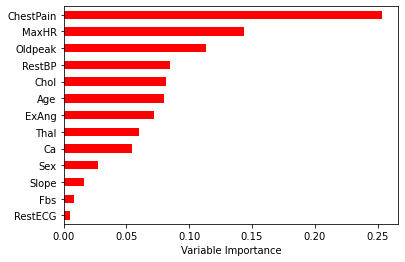

In [7]:
Importance = pd.DataFrame({'Importance':feature_importances}, index = X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.2.4 Random Forest

1. 用有放回的抽样方法（bootstrap）从样本集中选取n个样本作为一个训练集


2. 用抽样得到的样本集生成一棵决策树。在生成的每一个结点：


* 随机不重复地选择d个特征
* 利用这d个特征分别对样本集进行划分，找到最佳的划分特征（可用基尼系数、增益率或者信息增益判别）


3. 重复步骤1到步骤2共n次，n即为随机森林中决策树的个数。


4. 用训练得到的随机森林对测试样本进行预测，并用票选法决定预测的结果。



![title](img/Random_Forest.PNG)

In [8]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

random_forest_clf_p = RandomForestClassifier(n_estimators=100, max_features=None,
                                           random_state=0, oob_score=False)
random_forest_clf_half = RandomForestClassifier(n_estimators=100, max_features=0.5,
                                           random_state=0, oob_score=False)
random_forest_clf_sqrt = RandomForestClassifier(n_estimators=100, max_features='sqrt',
                                           random_state=0, oob_score=False)

random_forest_clf_p.fit(X_train,y_train)
random_forest_clf_half.fit(X_train,y_train)
random_forest_clf_sqrt.fit(X_train,y_train)

y_test_pred_p = random_forest_clf_p.predict(X_test)
y_test_pred_half = random_forest_clf_half.predict(X_test)
y_test_pred_sqrt = random_forest_clf_sqrt.predict(X_test)

print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_p)))
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_half)))
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_sqrt)))

random_forest test_accuracy: 0.7986577181208053
random_forest test_accuracy: 0.8053691275167785
random_forest test_accuracy: 0.8187919463087249


max_features：
* If int, then consider max_features features at each split.
* If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
* If “auto”, then max_features=sqrt(n_features).
* If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
* If “log2”, then max_features=log2(n_features).
* If None, then max_features=n_features.


In [9]:
# 生成画图所需数据表格框架
frame_index = range(1,51) 
frame_columns = [ 'Number of Trees', 'm=p','m=p/2','m=sqrt(p)']
frame = pd.DataFrame(index = frame_index, columns = frame_columns)
frame['Number of Trees'] = np.linspace(10,500,50)

In [10]:
# 把设置不同参数的随机森林模型并获取指标封装到一个短函数
def RandomFroest(tree_num, max_feature):
    model = RandomForestClassifier(n_estimators=tree_num, max_features=max_feature,
                            random_state=0, oob_score=False)
    model.fit(X_train,y_train)
    
    y_test_pred = model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error

# 计算不同特征选取比例下的分类错误率
def generate_frame():
    for i in frame_index:        
        frame.loc[i,'m=p'] = RandomFroest(10 * i, None)
        frame.loc[i,'m=p/2'] = RandomFroest(10 * i, 0.5)
        frame.loc[i,'m=sqrt(p)'] = RandomFroest(10 * i, 'sqrt')
        print(i)
generate_frame()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [11]:
frame.head()

,Number of Trees,m=p,m=p/2,m=sqrt(p)
1,10.0,0.234899,0.221477,0.208054
2,20.0,0.221477,0.194631,0.187919
3,30.0,0.221477,0.208054,0.187919
4,40.0,0.214765,0.194631,0.181208
5,50.0,0.208054,0.181208,0.181208


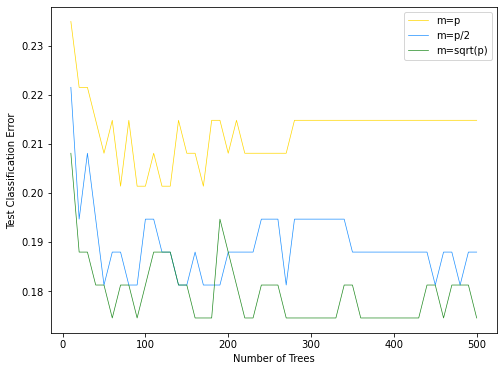

In [12]:
plt.figure(figsize=(8,6))
colors = ['gold','dodgerblue','forestgreen']
for i in range(3):
    plt.plot(frame['Number of Trees'], frame[frame.columns[1:][i]] ,
             label = frame.columns[1:][i],linestyle = '-',linewidth = 0.7, color = colors[i])
plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.legend()
plt.show()

In [13]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

random_forest_clf_OOB = RandomForestClassifier(n_estimators=100, max_features='auto',
                                           random_state=0, oob_score=True)
random_forest_clf_OOB.fit(X, y)
print('random_forest oob_score: %s'%(random_forest_clf_OOB.oob_score_))

# test_score
random_forest_clf_test = RandomForestClassifier(n_estimators=100, max_features='auto',
                                           random_state=0, oob_score=False)
random_forest_clf_test.fit(X_train,y_train)
y_test_pred = random_forest_clf_test.predict(X_test)
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

random_forest oob_score: 0.8080808080808081
random_forest test_accuracy: 0.8187919463087249


In [14]:
# 生成画图所需数据表格框架
# 生成1到30整数序列（np.linspace生成的数字格式为numpy.float64，不能用于循环索引）
Error_n_trees_frame_index = range(1,31) 

Error_n_trees_frame_columns = [ 'Number of Trees', 'Bagging_test', 'RandomForest_test',
                              'Bagging_OOB', 'RandomForest_OOB','Single_test']
Error_n_trees_frame = pd.DataFrame(index = Error_n_trees_frame_index, columns = Error_n_trees_frame_columns)
Error_n_trees_frame['Number of Trees'] = np.linspace(10,300,30)

# 把生成模型并获取指标封装到短函数
def Bagging_test(tree_num):
    Bagging_model = BaggingClassifier(DecisionTreeClassifier(),
                    n_estimators= tree_num, random_state=0,
                    bootstrap=True, oob_score=True,n_jobs=-1)
    Bagging_model.fit(X_train,y_train)
    
    y_test_pred = Bagging_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error
    
def Bagging_oob(tree_num):
    Bagging_model = BaggingClassifier(DecisionTreeClassifier(),
                    n_estimators= tree_num, random_state=0,
                    bootstrap=True, oob_score=True,n_jobs=-1)
    Bagging_model.fit(X,y)
    return 1 - Bagging_model.oob_score_
    
def RandomForest_test(tree_num):
    RandomForest_model = RandomForestClassifier(n_estimators=tree_num, max_features='sqrt',
                            random_state=0, oob_score=False)
    RandomForest_model.fit(X_train,y_train)
    
    y_test_pred = RandomForest_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error

def RandomForest_oob(tree_num):
    RandomForest_model = RandomForestClassifier(n_estimators=tree_num, max_features='sqrt',
                            random_state=0, oob_score=True)
    RandomForest_model.fit(X,y)
    return 1- RandomForest_model.oob_score_

def Single_tree_test():
    single_tree_model = DecisionTreeClassifier(random_state=0,max_depth=3)
    single_tree_model.fit(X_train,y_train)
    
    y_test_pred = single_tree_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error
    
# 计算不同树个数下的分类错误率
def generate_Error_n_trees_frame():
    for i in Error_n_trees_frame_index:        
        Error_n_trees_frame.loc[i,'Bagging_test'] = Bagging_test(10 * i)
        Error_n_trees_frame.loc[i,'RandomForest_test'] = RandomForest_test(10 * i)
        Error_n_trees_frame.loc[i,'Bagging_OOB'] = Bagging_oob(10 * i)
        Error_n_trees_frame.loc[i,'RandomForest_OOB'] = RandomForest_oob(10 * i)
        Error_n_trees_frame.loc[i,'Single_test'] = Single_tree_test()
        print(i)
generate_Error_n_trees_frame()

D:\anaconda3\envs\Accounting_Fraud\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\envs\Accounting_Fraud\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
D:\anaconda3\envs\Accounting_Fraud\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\envs\Accounting_Fraud\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
D:\anaconda3\envs\Accounting_Fraud\lib\site-packages\sklearn\ensemble\_forest.py:541: User

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [15]:
Error_n_trees_frame.head()

,Number of Trees,Bagging_test,RandomForest_test,Bagging_OOB,RandomForest_OOB,Single_test
1,10.0,0.201342,0.208054,0.262626,0.232323,0.281879
2,20.0,0.214765,0.187919,0.225589,0.205387,0.281879
3,30.0,0.208054,0.187919,0.23569,0.205387,0.281879
4,40.0,0.194631,0.181208,0.239057,0.191919,0.281879
5,50.0,0.214765,0.181208,0.222222,0.198653,0.281879


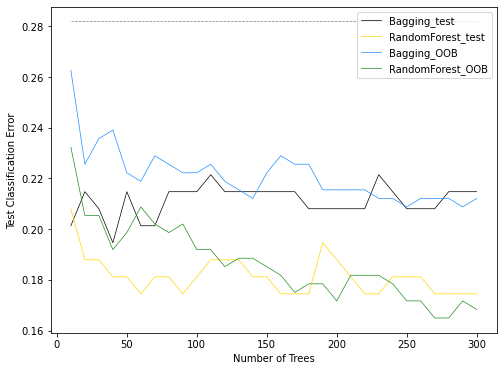

In [16]:
# 虚线是最大深度为3的单一决策树预测误差
plt.figure(figsize=(8,6))
colors = ['black','gold','dodgerblue','forestgreen']
plt.plot(Error_n_trees_frame['Number of Trees'], Error_n_trees_frame['Single_test'] ,
             label = '',linestyle = '--',linewidth = 0.7, color = 'grey')
for i in range(4):
    plt.plot(Error_n_trees_frame['Number of Trees'], Error_n_trees_frame[Error_n_trees_frame.columns[1:-1][i]] ,
             label = Error_n_trees_frame.columns[1:-1][i],linestyle = '-',linewidth = 0.7, color = colors[i])
plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.legend(loc = 'upper right')
plt.show()

## 8.2.5 Boosting

boosting的算法思路如下：

1. 对于训练集的每个样本建立权值$w_i$，增大被误分类的样本的权值


2. 进行迭代的过程中，每一步迭代都是一个弱分类器，需要用某种策略将其组合，作为最终模型。（例如AdaBoost给每个弱分类器一个权值，将其线性组合为最终分类器。误差越小的弱分类器，权值越大）

算法示例：
![title](img/boosting原理.PNG)

Boosting有三个超参数：

    
1. 树的数量，即M。与bagging和random forests不同，如果 M 太大，boosting 可能会过度拟合，尽管这种过度拟合往往会缓慢发生。我们使用交叉验证来选择M。

2. 收缩参数λ，一个小的正数。这控制了提升学习的速度。典型值为 0.01 或 0.001，正确的选择取决于问题。非常小的 λ 可能需要使用非常大的M值才能获得良好的性能。

3. 每棵树中的分裂数 d，它控制着增强集成的复杂性。通常 d = 1 效果很好，在这种情况下，每棵树都是一个树桩，由单个分割组成。

In [17]:
# Boosting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

boosting_clf_depth_1 =GradientBoostingClassifier(max_depth=1, n_estimators=1000, learning_rate=0.01, random_state=0)
boosting_clf_depth_2 =GradientBoostingClassifier(max_depth=2, n_estimators=1000, learning_rate=0.01, random_state=0)

boosting_clf_depth_1.fit(X_train,y_train)
boosting_clf_depth_2.fit(X_train,y_train)

y_test_pred_depth_1 = boosting_clf_depth_1.predict(X_test)
y_test_pred_depth_2 = boosting_clf_depth_2.predict(X_test)

print('Boosting test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_depth_1)))
print('Boosting test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_depth_2)))

Boosting test_accuracy: 0.8053691275167785
Boosting test_accuracy: 0.8322147651006712


由于boosting方法步长较少，树迭代次数较多，多次训练提升树模型运行时间较长，此处插入教材图片
![title](img/boosting.PNG)

# 8.3 Lab

## 8.3.1 Bagging and Random Forests

In [18]:
# 13 features in dataset
boston_df = pd.read_csv('数据/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [19]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [20]:
# Bagging
regr1 = BaggingRegressor(base_estimator = DecisionTreeRegressor(),n_estimators=100)
regr1.fit(X_train, y_train)
pred = regr1.predict(X_test)
metrics.mean_squared_error(y_test, pred)

16.743633379446635

Text(0, 0.5, 'y_test')

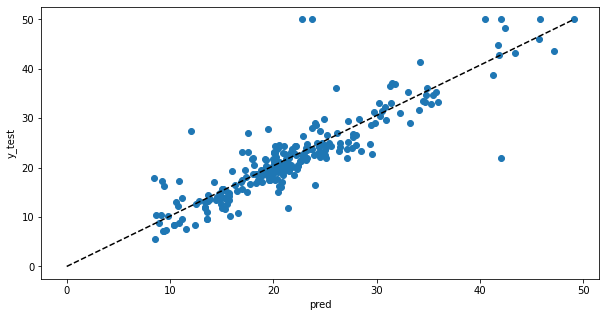

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(pred, y_test, label='medv')
plt.plot([0, max(pred)], [0, max(y_test)], '--k')
plt.xlabel('pred')
plt.ylabel('y_test')

In [22]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=0,n_estimators=100)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)
metrics.mean_squared_error(y_test, pred)

16.0181136798419

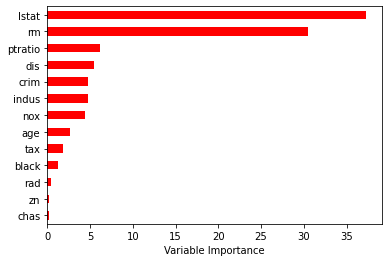

In [23]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.3.2 Boosting

In [24]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=0)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
metrics.mean_squared_error(y_test, regr.predict(X_test))

15.55180215646078

zn          0.010346
chas        0.128392
rad         0.141748
indus       0.414420
black       0.463254
nox         0.683027
age         0.934331
tax         1.152534
crim        2.564927
ptratio     4.516732
dis         6.143004
rm         27.940325
lstat      54.906958
dtype: float64


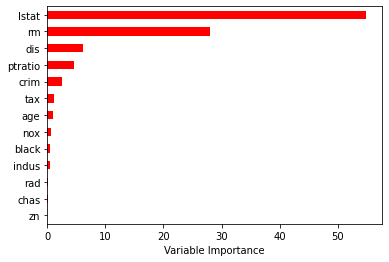

In [25]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Appendix: Tree Regression in *Machine Learning in Action*

以下代码以字典结构创建了一颗回归树：

In [26]:
from numpy import *
from pylab import plot, show
import os
## 数据载入
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

## 数据处理
# 通过数组过滤，将数据集切分成两个子集
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

In [27]:
# 测试数据集切分函数
testMat = mat(eye(4))
print(testMat)

mat0, mat1 = binSplitDataSet(testMat,1,0.5)
print(mat0,mat1)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[0. 1. 0. 0.]] [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [28]:
## 回归树的切分函数
# 生成叶节点——目标变量的均值
def regLeaf(dataSet):  # returns the value used for each leaf
    return mean(dataSet[:, -1])

# 误差估计函数_目标变量的平方误差
def regErr(dataSet):
    return var(dataSet[:, -1]) * shape(dataSet)[0]

# 核心函数—— 寻找最佳切分点
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    # 停止设定变量
    tolS = ops[0]  # 容许的误差一下降值
    tolN = ops[1]  # 切分最小样本数
    # if all the target variables are the same value: quit and return value
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:  # exit cond 1
        return None, leafType(dataSet)

    # 初始化
    m, n = shape(dataSet)
    # the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = inf
    bestIndex = 0
    bestValue = 0

    # 在所有特征值和和这个特征值的所有取值上遍历
    for featIndex in range(n - 1):
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            # 切分
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 寻找最低误差切分
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS

    # if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS:
        return None, leafType(dataSet)  # exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    
    # if 切分出的数据集太小—— 抛弃这个切分
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):  # exit cond 3
        return None, leafType(dataSet)
    return bestIndex, bestValue  # returns the best feature to split on and the value used for that split

## 创建树的整体函数
def createTree(dataSet, leafType=regLeaf, errType=regErr,
               ops=(1, 4)):  # assume dataSet is NumPy Mat so we can array filtering
    # 数据集切分——训练集和便签集
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)  # choose the best split
    # Todo:确定最佳切分的函数在后面实现
    
    # 递归停止条件
    if feat == None:
        return val  # if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

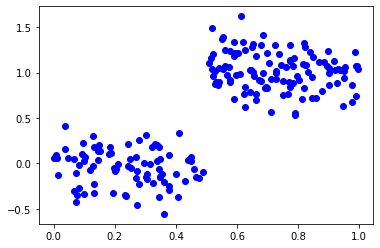

In [29]:
myDat = loadDataSet(r'数据\ex00.txt')
myMat = mat(myDat)
plot(myMat[:,0],myMat[:,1], 'bo')
show()

In [30]:
print(createTree(myMat))

{'spInd': 0, 'spVal': 0.48813, 'left': 1.0180967672413792, 'right': -0.04465028571428572}


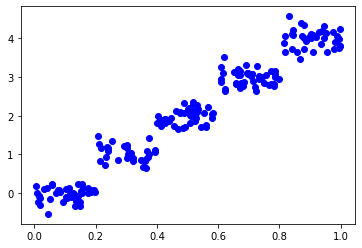

In [31]:
myDat1 = loadDataSet(r'数据\ex0.txt')
myMat1 = mat(myDat1)
plot(myMat1[:,1],myMat1[:,2], 'bo')
show()

In [32]:
print(createTree(myMat1))

{'spInd': 1, 'spVal': 0.39435, 'left': {'spInd': 1, 'spVal': 0.582002, 'left': {'spInd': 1, 'spVal': 0.797583, 'left': 3.9871632, 'right': 2.9836209534883724}, 'right': 1.980035071428571}, 'right': {'spInd': 1, 'spVal': 0.197834, 'left': 1.0289583666666666, 'right': -0.023838155555555553}}


参考原文：

知-阿泽：【机器学习】决策树（中）——Random Forest、Adaboost、GBDT （非常详细）
https://zhuanlan.zhihu.com/p/86263786

CSDN-Chercheer：利用sklearn进行集成学习之相关理论
https://blog.csdn.net/CherDW/article/details/54915774?utm_source=blogxgwz2